In [168]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 400
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

import plotly 
import plotly.express as px
# from plotly import tools, subplots
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# import plotly.express as px

# Modeling
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# cf.) function

In [41]:
def read_file(filename):
    df = pd.read_csv(f'{filename}')
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

def dual_countplot(col, train, test, figsize=(14,8), pallete="Set2", flip=True):
    plt.rcParams["figure.figsize"] = figsize
    fig, ax = plt.subplots(ncols=2)
    if flip:
        sns.countplot(y=train[col],palette=pallete,order=sorted(train[col].unique()),ax=ax[0]).set_title("train")
        sns.countplot(y=test[col],palette=pallete,order=sorted(test[col].unique()),ax=ax[1]).set_title("test")
    else:
        sns.countplot(x=train[col],palette=pallete,order=sorted(train[col].unique()),ax=ax[0]).set_title("train")
        sns.countplot(x=test[col],palette=pallete,order=sorted(test[col].unique()),ax=ax[1]).set_title("test")
    plt.tight_layout()
    plt.show()
    
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [3]:
# filepath = "../Daesamanlap/External"
# housing = pd.read_csv(os.path.join(filepath,'external_data.csv'))
# print(housing.columns)
# housing.columns = ['기관명', '광역시도코드', '지역', '시군구코드', '시군구명', '단지명', '도로명주소', '총세대수',
#        '공급유형', '형명', '전용면적', '공용면적', '임대건물구분', '주차수', '기본임대보증금', '기본월임대료',
#        '기본전환보증금']
# print(housing.columns)

In [4]:
# filepath = '../Daesamanlap/ProcessedData'
# train = pd.read_csv(os.path.join(filepath,'train_processed.csv'))
# test = pd.read_csv(os.path.join(filepath,'test_processed.csv'))
# check_NA(train)
# check_NA(test)
# train.shape, test.shape

In [43]:
filepath = '../ProcessedData'
train = pd.read_csv(os.path.join(filepath,'merged_train.csv'))
test = pd.read_csv(os.path.join(filepath,'merged_test.csv'))
check_NA(train)
check_NA(test)
train.shape, test.shape
r_train = deepcopy(train)
r_test = deepcopy(test)

NA check
...There's no NA
NA check
...There's no NA


In [412]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율'],
      dtype='object')

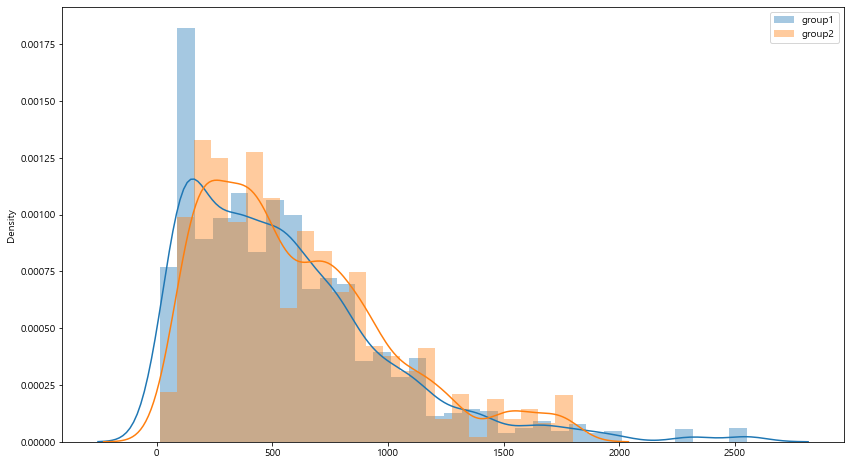

In [234]:
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(a=train['등록차량수'], label='group1')
sns.distplot(a=train['단지내주차면수'], label='group2')
plt.xlabel('')
plt.legend()
plt.show()

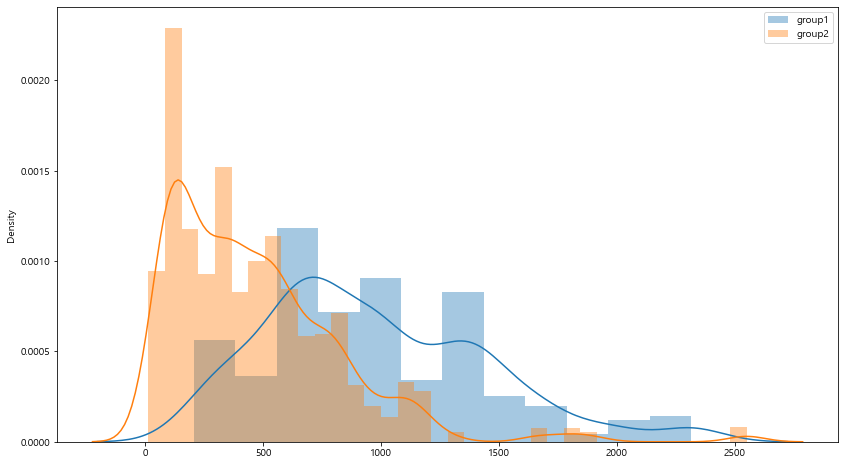

In [235]:
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(a=train.loc[train.총세대수<train.단지내주차면수,'등록차량수'], label='group1')
sns.distplot(a=train.loc[train.총세대수>train.단지내주차면수,'등록차량수'], label='group2')
plt.xlabel('')
plt.legend()
plt.show()

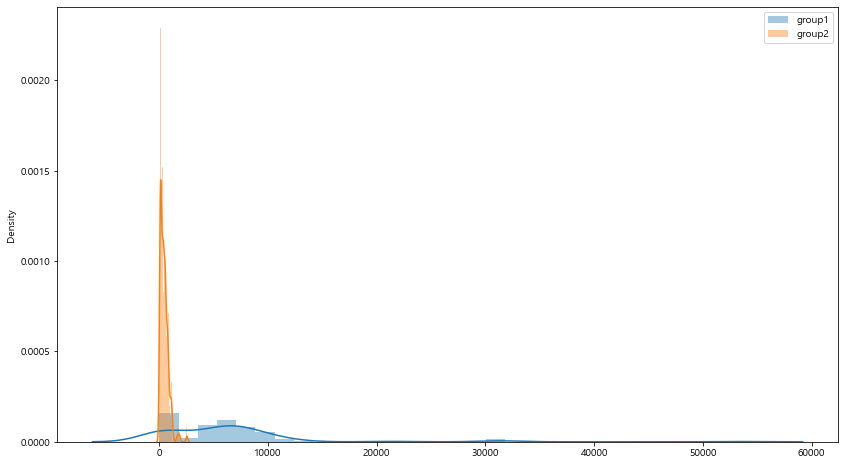

In [236]:
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(a=train.loc[train.총세대수<train.단지내주차면수,'연면적'], label='group1')
sns.distplot(a=train.loc[train.총세대수>train.단지내주차면수,'등록차량수'], label='group2')
plt.xlabel('')
plt.legend()
plt.show()

In [237]:
train['세대당_등록차량수'] = train['등록차량수']/train['총세대수']
train['세대당_단지내주차면수'] = train['단지내주차면수']/train['총세대수']

In [238]:
train.지역.nunique()

16

In [239]:
group1 = ['세종특별자치시','경기도','서울특별시','대구광역시','대전광역시','울산광역시','부산광역시','광주광역시']
group2 = ['충청북도','충청남도','전라남도','전라북도', '경상남도','경상북도','강원도','제주특별자치도']
len(set(group1+group2))

16

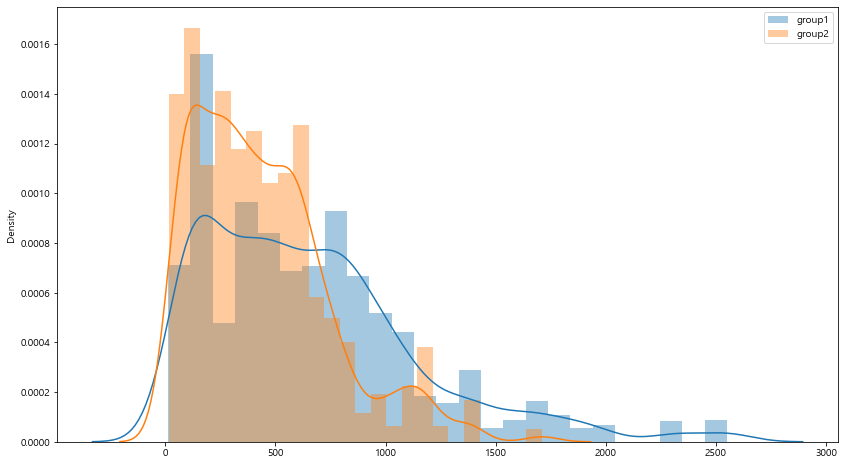

In [240]:
col = "등록차량수"
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1')
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2')
plt.xlabel('')
plt.legend()
plt.show()

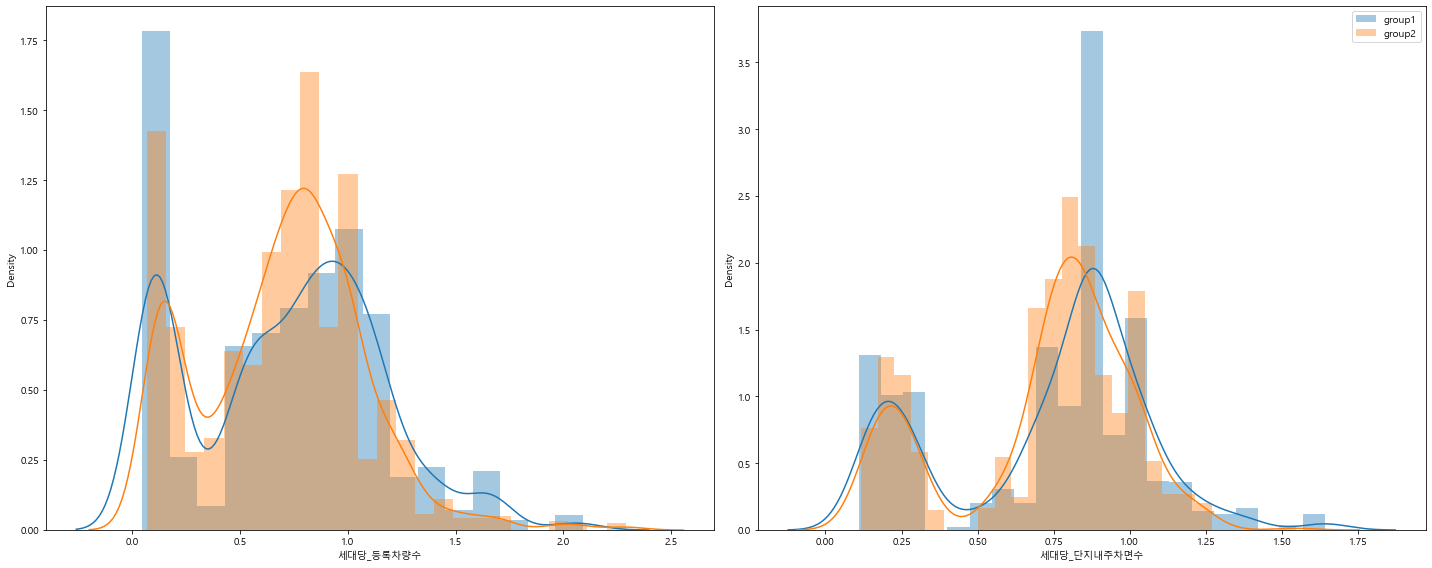

In [241]:
col = "세대당_등록차량수"
col2 = "세대당_단지내주차면수"
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group1),col2], label='group1',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group2),col2], label='group2',ax=ax[1])
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

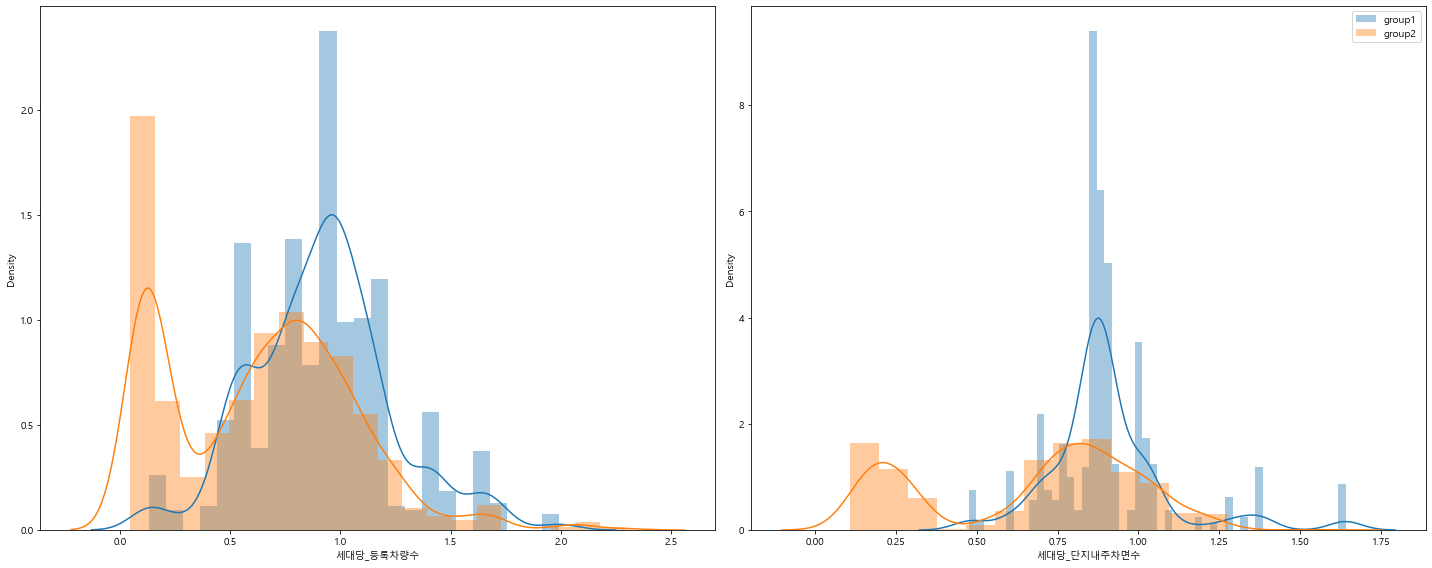

In [242]:
group1 = ['세종특별자치시','경기도','서울특별시']
group2 = ['충청북도','충청남도','전라남도','전라북도', '경상남도','경상북도','강원도','제주특별자치도','대구광역시','대전광역시','울산광역시','광주광역시','부산광역시']

col = "세대당_등록차량수"
col2 = "세대당_단지내주차면수"
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group1),col2], label='group1',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group2),col2], label='group2',ax=ax[1])
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

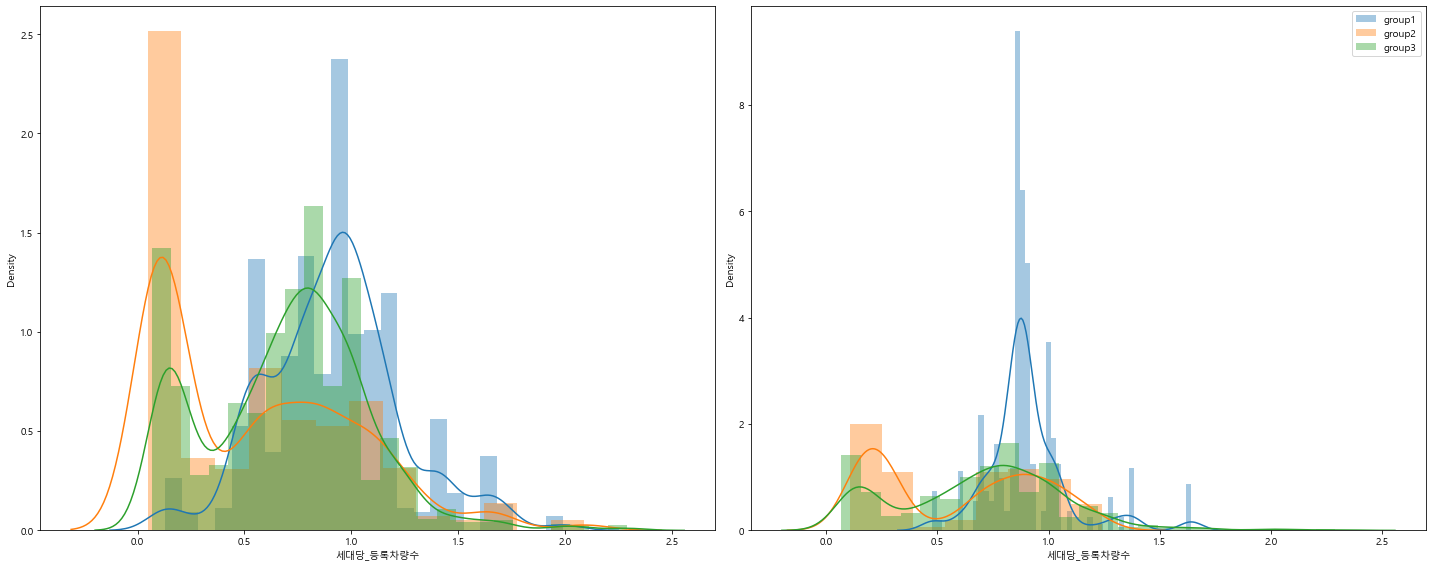

In [243]:
group1 = ['세종특별자치시','경기도','서울특별시']
group2 = ['대구광역시','대전광역시','울산광역시','광주광역시','부산광역시']
group3 = ['충청북도','충청남도','전라남도','전라북도', '경상남도','경상북도','강원도','제주특별자치도']

col = "세대당_등록차량수"
col2 = "세대당_단지내주차면수"
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group3),col], label='group3',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group1),col2], label='group1',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group2),col2], label='group2',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group3),col], label='group3',ax=ax[1])
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

16


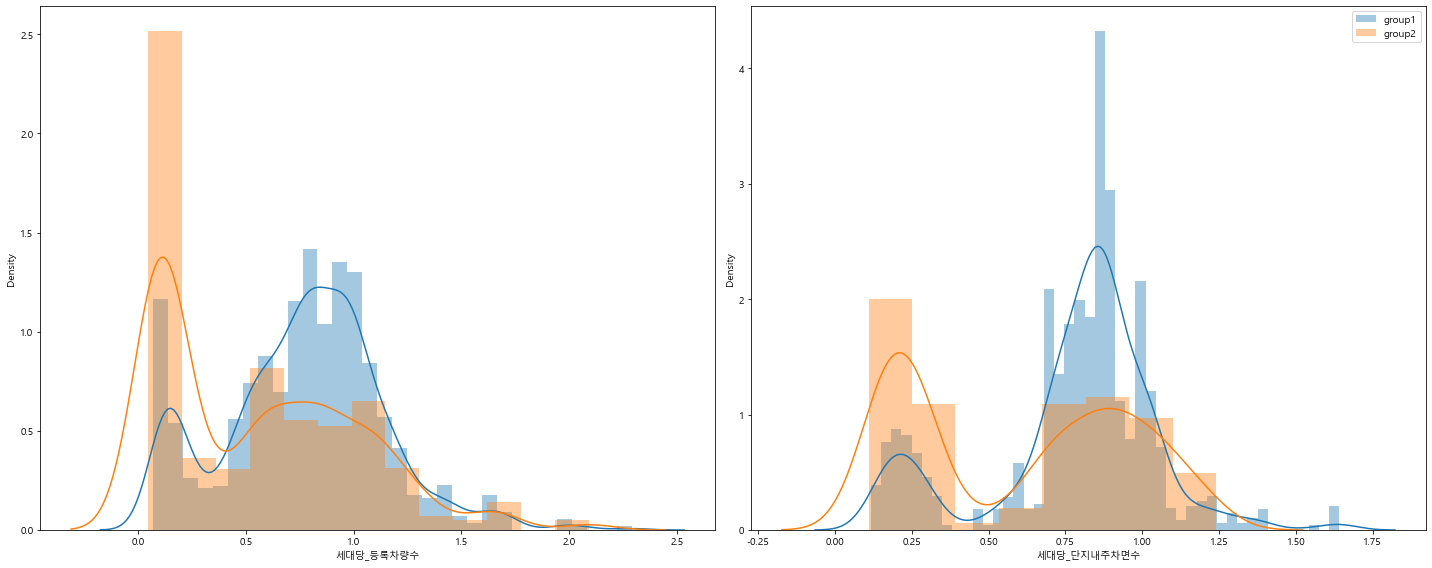

In [244]:
group1 = ['세종특별자치시','경기도','서울특별시','충청북도','충청남도','전라남도','전라북도', '경상남도','경상북도','강원도','제주특별자치도']
group2 = ['대구광역시','대전광역시','울산광역시','광주광역시','부산광역시']
print(len(set(group1+group2)))

col = "세대당_등록차량수"
col2 = "세대당_단지내주차면수"
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group1),col2], label='group1',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group2),col2], label='group2',ax=ax[1])
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

In [245]:
train[['지역','등록차량수','단지내주차면수','세대당_등록차량수','세대당_단지내주차면수','연면적','전용면적','임대료','임대보증금']].groupby('지역').mean().sort_values("세대당_등록차량수")

,등록차량수,단지내주차면수,세대당_등록차량수,세대당_단지내주차면수,연면적,전용면적,임대료,임대보증금
지역,,,,,,,,
부산광역시,316.5457,467.7134,0.2636,0.3706,"3,139.5067",47.2144,"4,124,834.2340","11,656,859.2461"
충청남도,239.1582,262.0570,0.4207,0.4499,"2,273.8530",39.2008,"550,449.0797","13,729,270.5277"
대전광역시,535.3947,693.2331,0.4834,0.5856,"3,874.3761",47.2811,"331,468.2142","22,146,892.9449"
경상남도,422.7642,475.7398,0.5942,0.6558,"2,656.4386",42.1941,"343,823.7544","18,446,008.7290"
제주특별자치도,333.2198,377.3736,0.6205,0.6398,"1,457.6678",38.5544,"627,979.3585","31,034,356.3560"
강원도,388.2460,366.6791,0.7336,0.7024,"3,627.3457",45.1232,"285,339.1836","16,772,879.7056"
울산광역시,337.1176,406.4412,0.7524,0.7819,"3,287.4191",43.5029,"222,456.7647","28,439,970.5882"
전라북도,482.4220,482.7615,0.7865,0.7942,"2,626.6698",43.3400,"134,853.3028","19,154,669.7248"
전라남도,509.6803,531.2585,0.7966,0.8321,"2,624.9705",42.3748,"133,239.2517","15,990,530.6122"


16


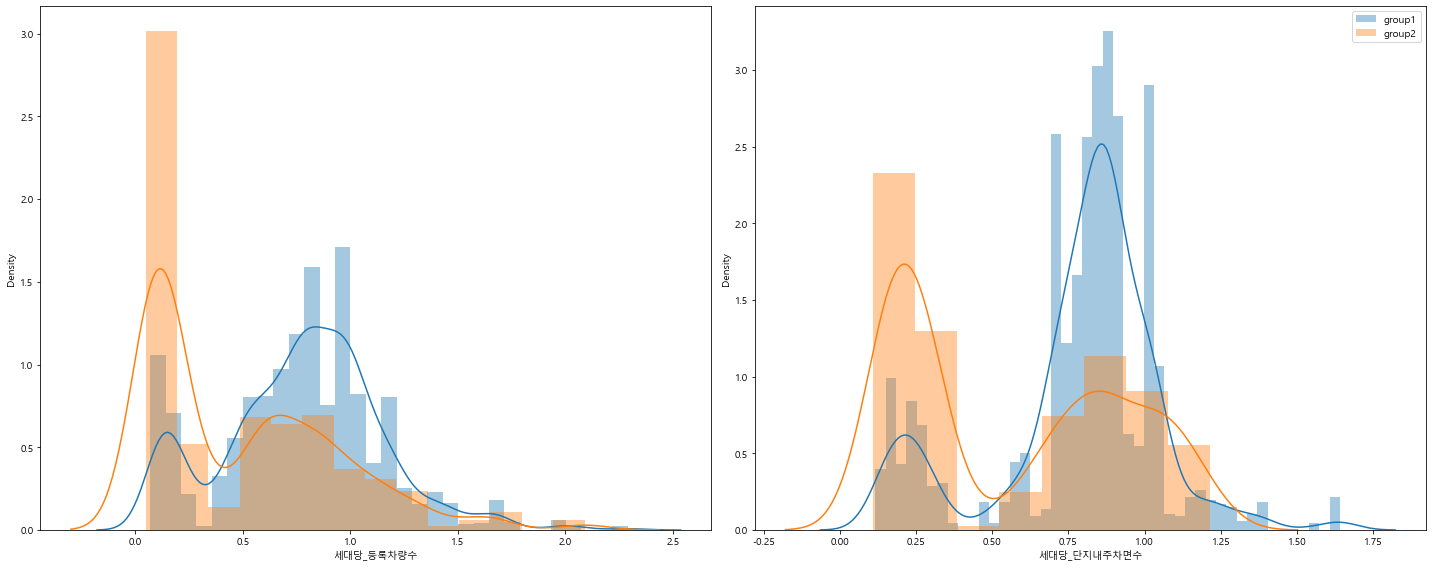

In [246]:
group1 = ['세종특별자치시','경기도','서울특별시','충청북도','충청남도','전라남도','전라북도', '경상남도','경상북도','강원도']
group2 = ['대구광역시','대전광역시','울산광역시','광주광역시' '경상남도','제주특별자치도','부산광역시']
print(len(set(group1+group2)))

col = "세대당_등록차량수"
col2 = "세대당_단지내주차면수"
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group1),col2], label='group1',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group2),col2], label='group2',ax=ax[1])
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

16


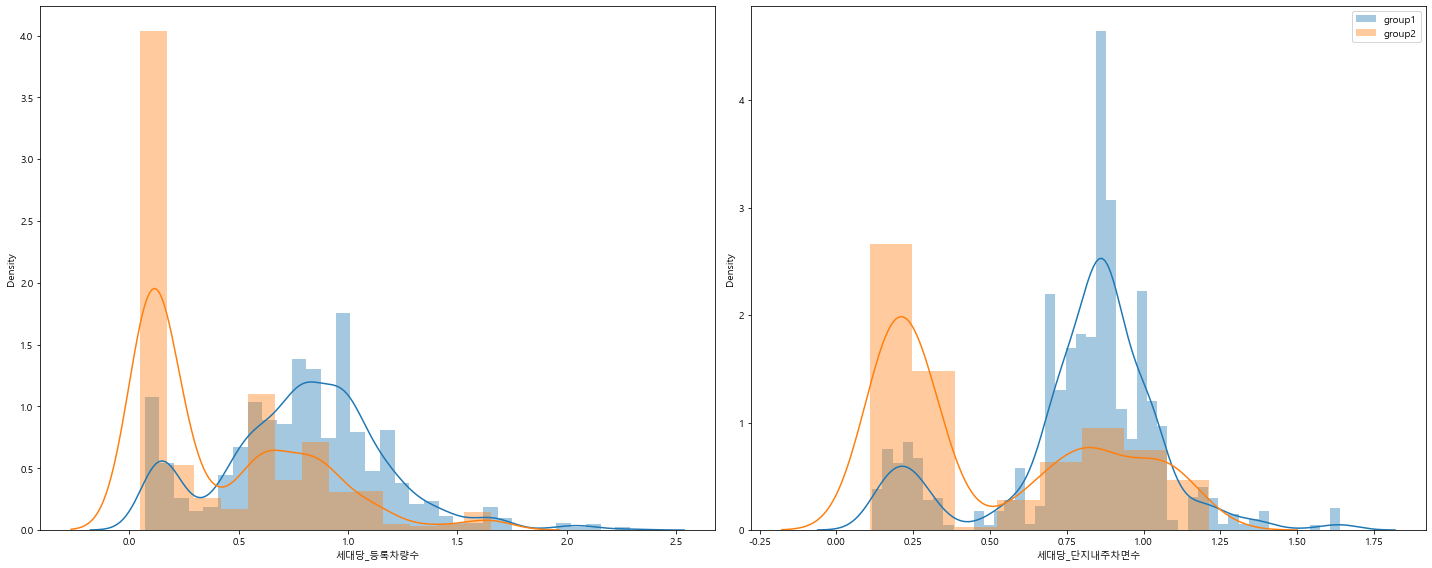

In [247]:
group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','충청남도','전라남도','전라북도', '경상남도','경상북도','강원도']
group2 = ['대전광역시','울산광역시','광주광역시' '경상남도','제주특별자치도','부산광역시']
print(len(set(group1+group2)))

col = "세대당_등록차량수"
col2 = "세대당_단지내주차면수"
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group1),col2], label='group1',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group2),col2], label='group2',ax=ax[1])
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

16


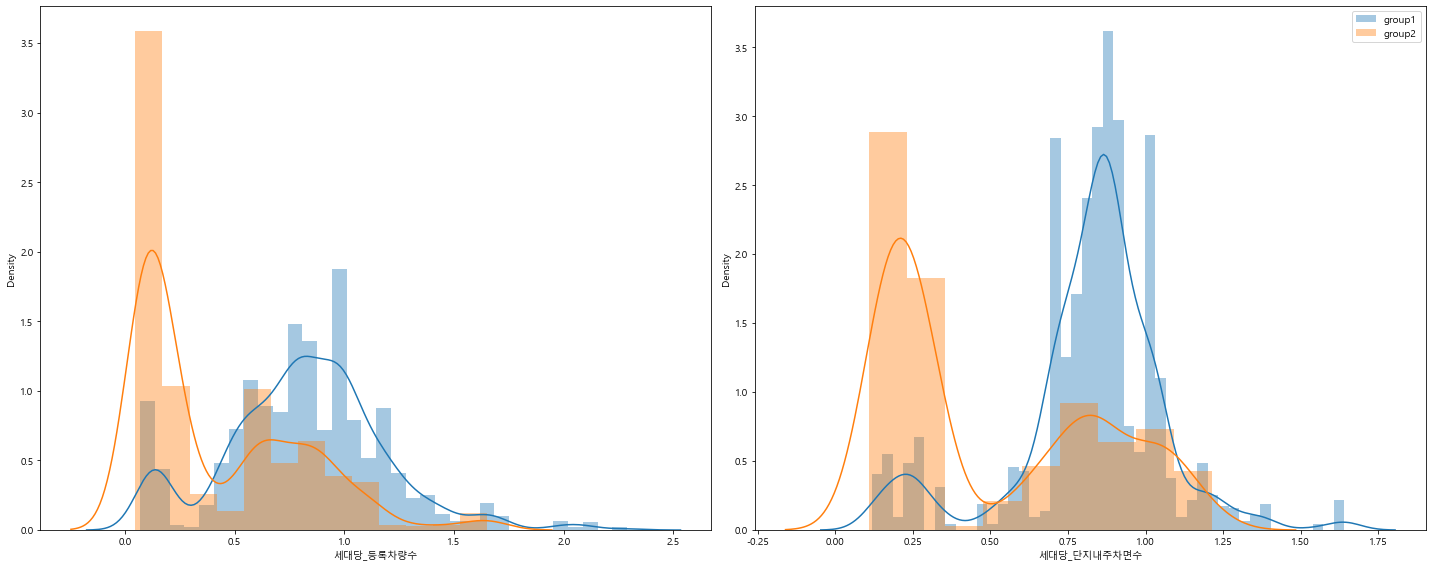

In [269]:
group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도', '경상남도','경상북도','강원도']
group2 = ['대전광역시','울산광역시','광주광역시' '경상남도','제주특별자치도','부산광역시','충청남도']
print(len(set(group1+group2)))

col = "세대당_등록차량수"
col2 = "세대당_단지내주차면수"
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group1),col2], label='group1',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group2),col2], label='group2',ax=ax[1])
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

16


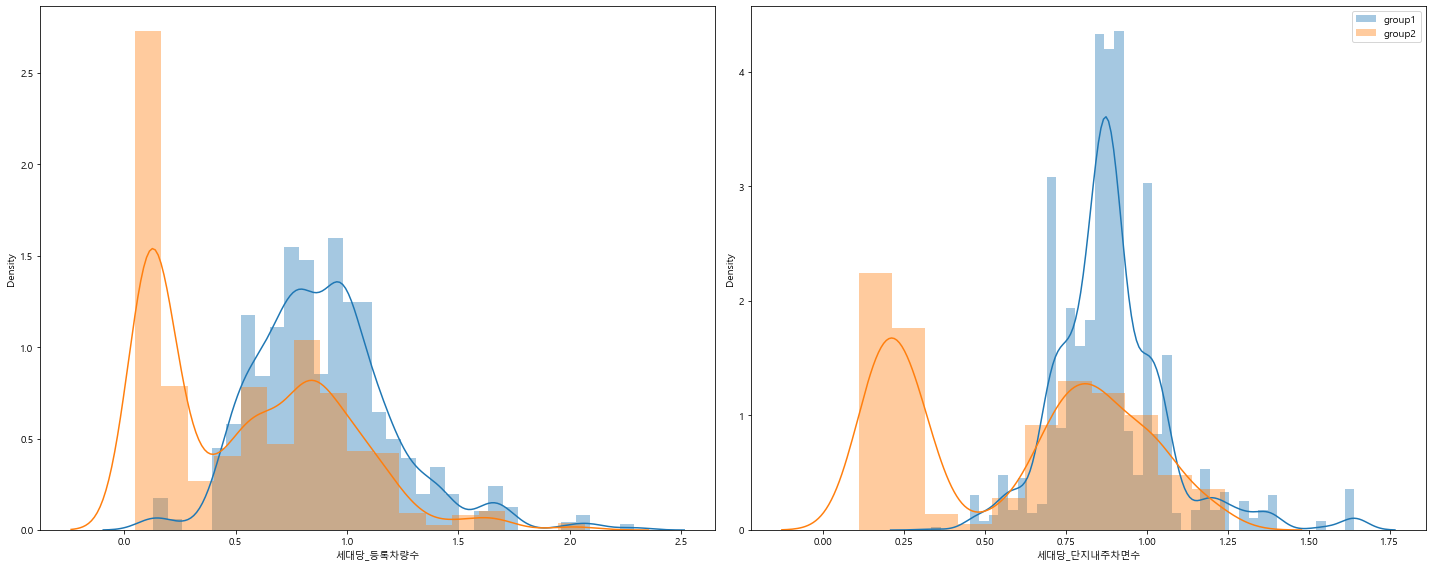

In [306]:
group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도']
group2 = ['대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도']
print(len(set(group1+group2)))

col = "세대당_등록차량수"
col2 = "세대당_단지내주차면수"
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group1),col2], label='group1',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group2),col2], label='group2',ax=ax[1])
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

16


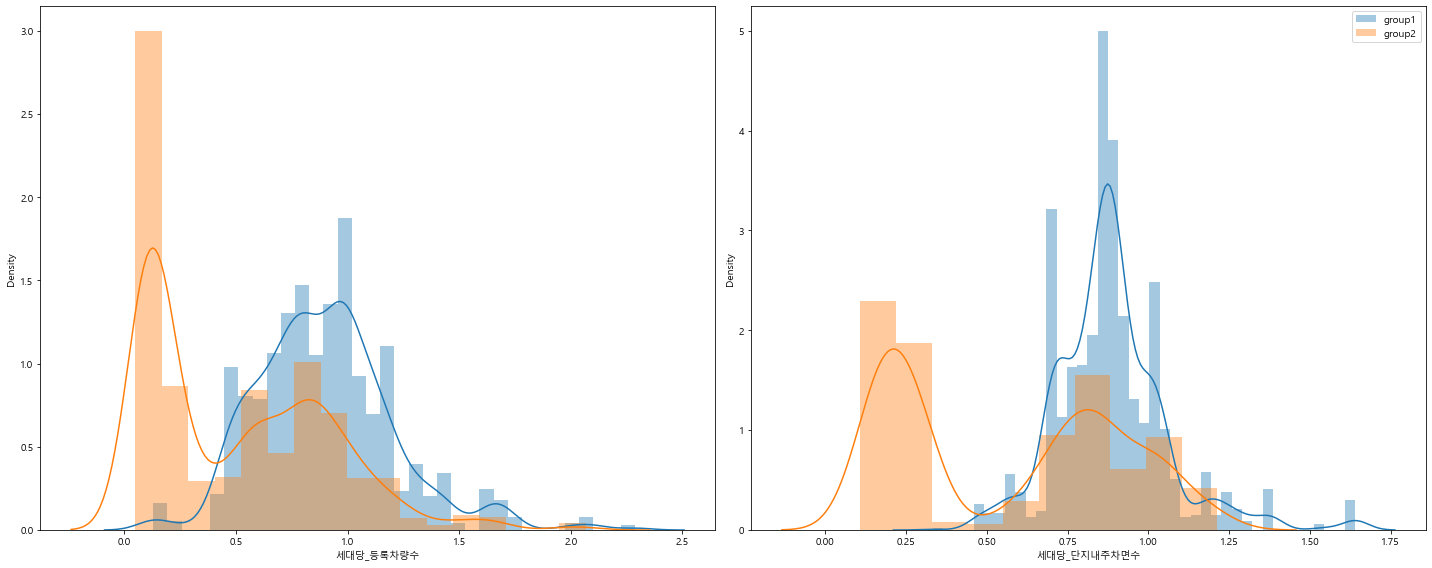

In [311]:
group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도','광주광역시']
group2 = ['대전광역시','울산광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도']
print(len(set(group1+group2)))

col = "세대당_등록차량수"
col2 = "세대당_단지내주차면수"
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
sns.distplot(a=train.loc[train.지역.isin(group1),col], label='group1',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group2),col], label='group2',ax=ax[0])
sns.distplot(a=train.loc[train.지역.isin(group1),col2], label='group1',ax=ax[1])
sns.distplot(a=train.loc[train.지역.isin(group2),col2], label='group2',ax=ax[1])
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

In [250]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율',
       '세대당_등록차량수', '세대당_단지내주차면수'],
      dtype='object')

In [301]:
target = "등록차량수"
col_drop = ["단지코드","지역","단지명","도로명주소","위도","경도","subway_name",'0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율','세대당_등록차량수']

In [210]:
tr = train.loc[train.지역.isin(group1)].drop(col_drop, axis=1)
tr_drop = tr.drop(target, axis=1)
tr_dum = pd.get_dummies(tr_drop)
X = np.array(tr_dum)
y = np.array(tr[target])
fit = LinearRegression().fit(X,y)

In [211]:
coef1 = pd.DataFrame({'x_col':tr_dum .columns,'coef':fit.coef_})

In [212]:
tr = train.loc[train.지역.isin(group1)].drop(col_drop, axis=1)
tr_drop = tr.drop(target, axis=1)
scaler = StandardScaler() 
tr_num = tr_drop.select_dtypes(include="number")
tr_num_scale = scaler.fit_transform(tr_num)
tr_obj = np.array(pd.get_dummies(tr_drop.select_dtypes(exclude="number")))
X = np.concatenate((tr_num_scale,tr_obj),axis=1)
y = np.array(tr[target])
fit = LinearRegression().fit(X,y)

In [213]:
coef2 =pd.DataFrame({'x_col':tr_dum.columns,'coef':fit.coef_})

In [214]:
tr = train.loc[train.지역.isin(group1)].drop(col_drop, axis=1)
tr_drop = tr.drop(target, axis=1)
scaler = StandardScaler() 
tr_num = tr_drop.select_dtypes(include="number")
tr_obj = np.array(pd.get_dummies(tr_drop.select_dtypes(exclude="number")))
X = scaler.fit_transform(np.concatenate((tr_num_scale,tr_obj),axis=1))
y = np.array(tr[target])
fit = LinearRegression().fit(X,y)

In [215]:
coef3 = pd.DataFrame({'x_col':tr_dum.columns,'coef':fit.coef_})

In [217]:
pd.merge(pd.merge(coef1, coef2, on="x_col"),coef3, on="x_col").T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
x_col,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,연면적,subway_dist,환승역 수,총인구수,세대당_인구,남/여비율,남/여_0~19세,남/여_20~39세,남/여_40~69세,남/여_70세이상,0~19세_비율,...,공급유형_공공임대(10년),공급유형_공공임대(50년),공급유형_공공임대(분납),공급유형_국민임대,공급유형_영구임대,공급유형_임대상가,공급유형_장기전세,공급유형_행복주택,자격유형_A,자격유형_B,자격유형_C,자격유형_D,자격유형_E,자격유형_G,자격유형_H,자격유형_I,자격유형_J,자격유형_K,자격유형_L,자격유형_N
coef_x,0.0660,-0.1287,-0.0305,-3.8613,-0.0000,0.0000,-5.7155,6.8077,0.9691,0.0020,9.0423,23.2762,-0.0003,-71.4849,-19.7625,-12.1799,-85.9549,-36.2165,-40.0628,119.6922,...,49.5248,-37.8225,20.8454,-11.7471,-116.7318,-12.5806,102.0730,6.4388,-0.3990,14.0820,79.8946,-12.5806,59.3939,-247.2963,23.6918,76.7748,-35.1456,97.7441,36.2071,-92.3668
coef_y,27.3820,0.0471,-0.5190,-43.2945,-19.5198,1.8743,-0.7862,15.4185,371.9402,8.7063,3.3710,2.8601,-10.7592,-10.6715,-3.3336,-5.2070,-8.4046,-1.2899,0.5802,"-7,954,760,214,989,532.0000",...,"106,987,300,775,032.3438","106,987,300,774,941.1250","106,987,300,775,028.0469","106,987,300,774,978.2969","106,987,300,774,864.7656","-272,326,842,139,694.9062","106,987,300,775,045.0781","38,169,489,181,999.0781","75,829,991,036,822.4375","75,829,991,036,832.1875","75,829,991,036,908.8281","-428,373,788,144,789.1875","75,829,991,036,889.6875","75,829,991,036,576.1094","75,829,991,036,841.9219","75,829,991,036,905.3594","144,647,802,629,781.7500","144,647,802,629,912.4688","144,647,802,629,854.3125","144,647,802,629,713.9688"
coef,27.3820,-0.0656,-5.3696,-42.8084,-24.2638,1.2026,-2.6291,19.7580,373.8579,9.0632,0.9452,6.9174,-8.0585,-21.1527,-4.9272,-1.1864,-12.9791,-0.9221,-3.8890,"-6,988,935,256,283,507.0000",...,"674,503,443,797,303.7500","113,228,360,578,502.7031","169,590,660,941,431.7812","1,049,571,503,989,493.6250","444,786,344,874,601.6250","266,089,349,551,958.2812","169,590,660,941,439.0938","1,185,585,996,416,126.2500","-99,944,423,233,386.9375","-24,548,997,335,257.8086","-26,753,054,771,712.8008","226,317,736,781,632.0312","-22,114,038,600,700.8945","-15,210,830,515,498.1797","-60,283,786,999,857.0000","-32,429,069,722,880.7617","-427,471,833,805,464.4375","-286,565,142,756,334.1250","-261,085,212,451,119.9375","-238,622,876,486,706.2188"


In [331]:
def reg_group(train,group1,col_drop,target):
    tr = train.loc[train.지역.isin(group1)].drop(col_drop, axis=1)
    tr_drop = tr.drop(target, axis=1)
    scaler = StandardScaler() 
    tr_num = tr_drop.select_dtypes(include="number")
    X = scaler.fit_transform(tr_num)
    y = np.array(tr[target])
    result = OLS(y, X).fit()
    return tr_num.columns, result.summary(), result.params

In [337]:
group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도']
group2 = ['대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도']
target = "등록차량수"
col_drop = ["단지코드","지역","단지명","도로명주소","위도","경도","subway_name",'0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율','세대당_등록차량수']
col, summary1, params1 = reg_group(train,group1,col_drop,target)
_, summary2, params2 = reg_group(train,group2,col_drop,target)

In [338]:
coef1 = pd.DataFrame({'x_col':col,'group1':params1,'group2':params2})
coef1.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
x_col,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,연면적,subway_dist,환승역 수,총인구수,세대당_인구,남/여비율,남/여_0~19세,남/여_20~39세,남/여_40~69세,남/여_70세이상,세대당_단지내주차면수
group1,31.3376,47.2228,11.9575,-108.5951,-0.1319,33.9926,-2.6787,22.8405,365.6604,0.8112,-1.3356,2.6835,-42.0621,16.0339,41.2207,22.6067,20.3325,-29.5361,-13.9344,-17.5810
group2,-48.9779,-2.1477,3.4394,-25.8396,24.6612,8.6105,-15.9488,5.7932,319.2979,2.7913,-23.5041,4.9348,-31.5417,40.1320,31.2390,-19.0843,3.4442,-27.6089,-9.0842,39.2620


In [339]:
group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','경상북도']
group2 = ['대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도','전라남도','전라북도']
target = "등록차량수"
col_drop = ["단지코드","지역","단지명","도로명주소","위도","경도","subway_name",'0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율','세대당_등록차량수']
col, summary3, params3 = reg_group(train,group1,col_drop,target)
_, summary4, params4 = reg_group(train,group2,col_drop,target)

In [340]:
coef2 = pd.DataFrame({'x_col':col,'group1':params3,'group2':params4})
coef2.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
x_col,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,연면적,subway_dist,환승역 수,총인구수,세대당_인구,남/여비율,남/여_0~19세,남/여_20~39세,남/여_40~69세,남/여_70세이상,세대당_단지내주차면수
group1,74.5911,47.4591,12.3367,-138.9699,7.3231,18.3631,-3.9190,27.0813,340.5050,0.0873,22.8401,8.6475,-44.8623,21.5259,68.0293,14.3087,7.5884,-41.7062,-27.8065,-3.8669
group2,-51.1535,2.5845,4.1284,-22.2085,24.2241,3.6232,-19.5016,6.9632,320.8356,3.0461,-22.6719,5.2704,-29.1535,32.6507,28.8558,-12.5075,5.0323,-24.5089,-4.3034,23.9283


# Modeling

In [502]:
# filepath = '../ProcessedData'
# train = pd.read_csv(os.path.join(filepath,'merged_train.csv'))
# test = pd.read_csv(os.path.join(filepath,'merged_test.csv'))
# check_NA(train)
# check_NA(test)
# train.shape, test.shape

In [6]:
filepath = '../ProcessedData'
train = read_file(os.path.join(filepath,'merged_train.csv'))
test = read_file(os.path.join(filepath,'merged_test.csv'))
check_NA(train)
check_NA(test)
train.shape, test.shape

...There are 319 duplicates
...Remove them
shape: (2577, 34)
...There are 72 duplicates
...Remove them
shape: (936, 33)
NA check
...There's no NA
NA check
...There's no NA


((2577, 34), (936, 33))

## EDA_통합 기준 파생변수
자격유형 및 공급유형 재범주화는 은영 ver.

In [7]:
## train
# 상가비율 column 추가 & 임대건물구분 drop
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')
train.drop("임대건물구분", axis=1)

# 분양세대수 column 추가
train_sale = pd.DataFrame(train.groupby(['단지코드']).first()['총세대수'] - train.groupby(['단지코드']).sum()['전용면적별세대수'])
train_sale.columns = ["분양세대수"]
train_sale = train_sale.astype('int16')
train_sale.reset_index(inplace=True)
train = pd.merge(train, train_sale,on="단지코드")

# 세대당_가능주차면수 추가
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']

# 공가수비율 추가
train['공가수비율']= train.공가수/train.총세대수 

#대형전용면적 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

# std 추가
train["전용면적_std"] = train.groupby("단지코드").std().reset_index()["전용면적"]
train["전용면적별세대수_std"] = train.groupby("단지코드").std().reset_index()["전용면적별세대수"]
train["임대보증금_std"] = train.groupby("단지코드").std().reset_index()["임대보증금"]
train["임대료_std"] = train.groupby("단지코드").std().reset_index()["임대료"]
train.loc[train.전용면적_std.isna(),"전용면적_std"] = 0
train.loc[train.전용면적별세대수_std.isna(),"전용면적별세대수_std"] = 0
train.loc[train.임대보증금_std.isna(),"임대보증금_std"] = 0
train.loc[train.임대료_std.isna(),"임대료_std"] = 0

# 자격유형_카테고리 추가 & 자격유형 drop
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")

# 공급유형 재범주화
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'



## test
# 상가비율 column 추가 & 임대건물구분 drop
test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')
test.drop("임대건물구분", axis=1)

# 분양세대수 column 추가
test_sale = pd.DataFrame(test.groupby(['단지코드']).first()['총세대수'] - test.groupby(['단지코드']).sum()['전용면적별세대수'])
test_sale.columns = ["분양세대수"]
test_sale = test_sale.astype('int16')
test_sale.reset_index(inplace=True)
test = pd.merge(test, test_sale,on="단지코드")

# 세대당_가능주차면수 추가
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 추가
test['공가수비율']= test.공가수/test.총세대수 

#대형전용면적 추가
level = 85
test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# std 추가
test["전용면적_std"] = test.groupby("단지코드").std().reset_index()["전용면적"]
test["전용면적별세대수_std"] = test.groupby("단지코드").std().reset_index()["전용면적별세대수"]
test["임대보증금_std"] = test.groupby("단지코드").std().reset_index()["임대보증금"]
test["임대료_std"] = test.groupby("단지코드").std().reset_index()["임대료"]
test.loc[test.전용면적_std.isna(),"전용면적_std"] = 0
test.loc[test.전용면적별세대수_std.isna(),"전용면적별세대수_std"] = 0
test.loc[test.임대보증금_std.isna(),"임대보증금_std"] = 0
test.loc[test.임대료_std.isna(),"임대료_std"] = 0

# 자격유형_카테고리 추가 & 자격유형 drop
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
test= test.drop(columns="자격유형")

# 공급유형 재범주화
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

## 내가 새로 추가한 것

#### 세대수 대비 차량보유가 높은/낮은 지역 구분 -> 지역 drop
- group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도']
- group2 = ['대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도']

In [8]:
group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도']
group2 = ['대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도']    
train.loc[train.지역.isin(group1),"지역_카테고리"] = "high"
train.loc[train.지역.isin(group2),"지역_카테고리"] = "low"
test.loc[test.지역.isin(group1),"지역_카테고리"] = "high"
test.loc[test.지역.isin(group2),"지역_카테고리"] = "low"

#### 임대상가가 속한 아파트단지의 공급유형을 임대상가가 아닌 공급유형으로 통일 -> 임대상가와 상가비율 correlation 해결

In [9]:
sangga = train.loc[train.공급유형=="임대상가","단지코드"].unique()

In [10]:
# for i in sangga:
#     print(i)
#     print(train.loc[(train.단지코드==i)&(train.공급유형!="임대상가"),"공급유형"].unique())

In [11]:
# train.loc[train.단지코드.isin(["C1722","C1983","C2644"]),].iloc[:,:-19].sort_values("단지코드")

In [12]:
sangga_uni = list(set(sangga)-set(["C1722","C1983","C2644"]))
for i in sangga_uni:
    train.loc[train.단지코드==i,"공급유형"] = train.loc[(train.단지코드==i)&(train.공급유형!="임대상가"),"공급유형"]

In [13]:
col = "C1722"
idx = train.loc[(train.단지코드==col)&(train.공급유형=="임대상가"),"공급유형"].index
typ = train.loc[(train.단지코드==col)&(train.공급유형!="임대상가"),"공급유형"].unique()
print(len(idx))
print(typ)

2
['공공임대(50년)' '영구임대']


In [14]:
train.at[idx[0],"공급유형"] = typ[0]
train.at[idx[1],"공급유형"] = typ[1]

In [15]:
col = "C1983"
idx = train.loc[(train.단지코드==col)&(train.공급유형=="임대상가"),"공급유형"].index
typ = train.loc[(train.단지코드==col)&(train.공급유형!="임대상가"),"공급유형"].unique()
print(len(idx))
print(typ)

3
['공공임대(50년)' '영구임대']


In [16]:
train.at[idx[0],"공급유형"] = typ[0]
train.at[idx[1],"공급유형"] = typ[1]
train.at[idx[2],"공급유형"] = typ[0]

In [17]:
col = "C2644"
idx = train.loc[(train.단지코드==col)&(train.공급유형=="임대상가"),"공급유형"].index
typ = train.loc[(train.단지코드==col)&(train.공급유형!="임대상가"),"공급유형"].unique()
print(len(idx))
print(typ)

2
['공공임대(50년)' '영구임대']


In [18]:
train.at[idx[0],"공급유형"] = typ[0]
train.at[idx[1],"공급유형"] = typ[1]

#### 영구임대와 자격유형_카테고리2 correlation 해결 X - 모르겠음

<AxesSubplot:>

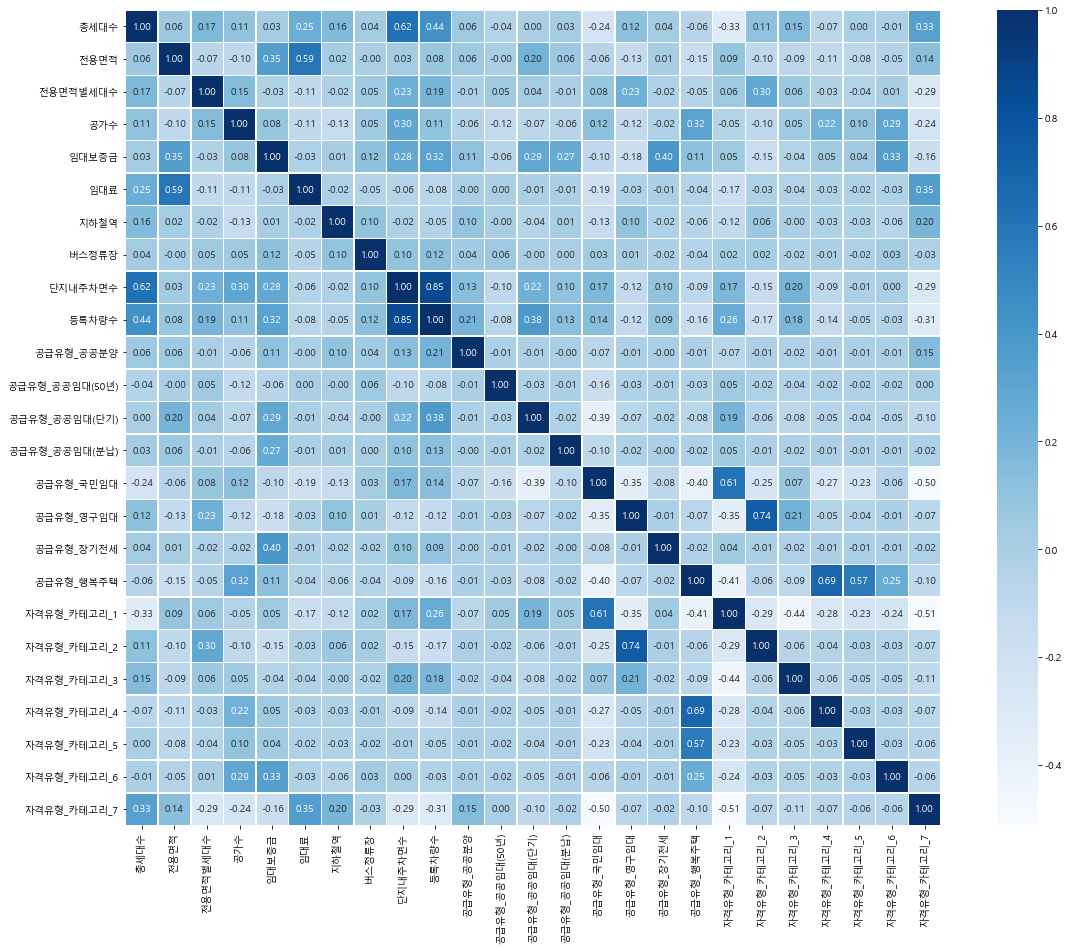

In [19]:
plt.subplots(figsize=(20,15))
sns.heatmap(pd.get_dummies(train[['총세대수','공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수','자격유형_카테고리']]).corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

In [20]:
pre_train = deepcopy(train)
pre_test = deepcopy(test)

## 1차원으로 변환

In [604]:
train = pre_train
test = pre_test

x_col = ['위도','경도','subway_name','도로명주소','단지명','지역','임대건물구분']
train = train.drop(x_col, axis=1)
X = train.drop('등록차량수',axis=1)
y = train[['등록차량수','단지코드']].groupby('단지코드').mean()['등록차량수']
train_one_num = pd.concat([X['단지코드'],X.drop('단지코드',axis=1).select_dtypes(include="number")],axis=1).groupby('단지코드').mean()
train_obj = pd.concat([train['단지코드'],pd.get_dummies(X.drop("단지코드",axis=1).select_dtypes(exclude="number"))],axis=1)
train_one_obj = train_obj.groupby('단지코드').sum()
train_one = pd.concat([train_one_num, train_one_obj],axis=1)


x_col = ['위도','경도','subway_name','도로명주소','단지명','지역','임대건물구분']
X = test.drop(x_col, axis=1)
test_one_num = pd.concat([X['단지코드'],X.drop('단지코드',axis=1).select_dtypes(include="number")],axis=1).groupby('단지코드').mean()
test_obj = pd.concat([test['단지코드'],pd.get_dummies(X.drop("단지코드",axis=1).select_dtypes(exclude="number"))],axis=1)
test_one_obj = test_obj.groupby('단지코드').sum()
test_one = pd.concat([test_one_num, test_one_obj],axis=1).reset_index(drop=True)
test_add = pd.DataFrame(np.zeros([test_one.shape[0],2]),columns=list(set(train_one)-set(test_one)))
test_one = pd.concat([test_one,test_add],axis=1)
test_one = test_one[train_one.columns]
print(set(train_one)-set(test_one))

set()


In [607]:
X_train, X_test, y_train, y_test = train_test_split(train_one, y, test_size=0.3, random_state=2021,shuffle=True)

In [608]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(
#     cat_features = obj_col,
#     n_estimators = 1000,
    loss_function = 'MAE')

In [615]:
model.fit(X_train, y_train,verbose=500)
tst_pred = model.predict(X_test)
mean_absolute_error(y_test,tst_pred)

0:	learn: 290.9280268	total: 9.91ms	remaining: 9.9s
500:	learn: 33.3426144	total: 3.79s	remaining: 3.78s
999:	learn: 17.0411573	total: 7.6s	remaining: 0us


104.48955626833862

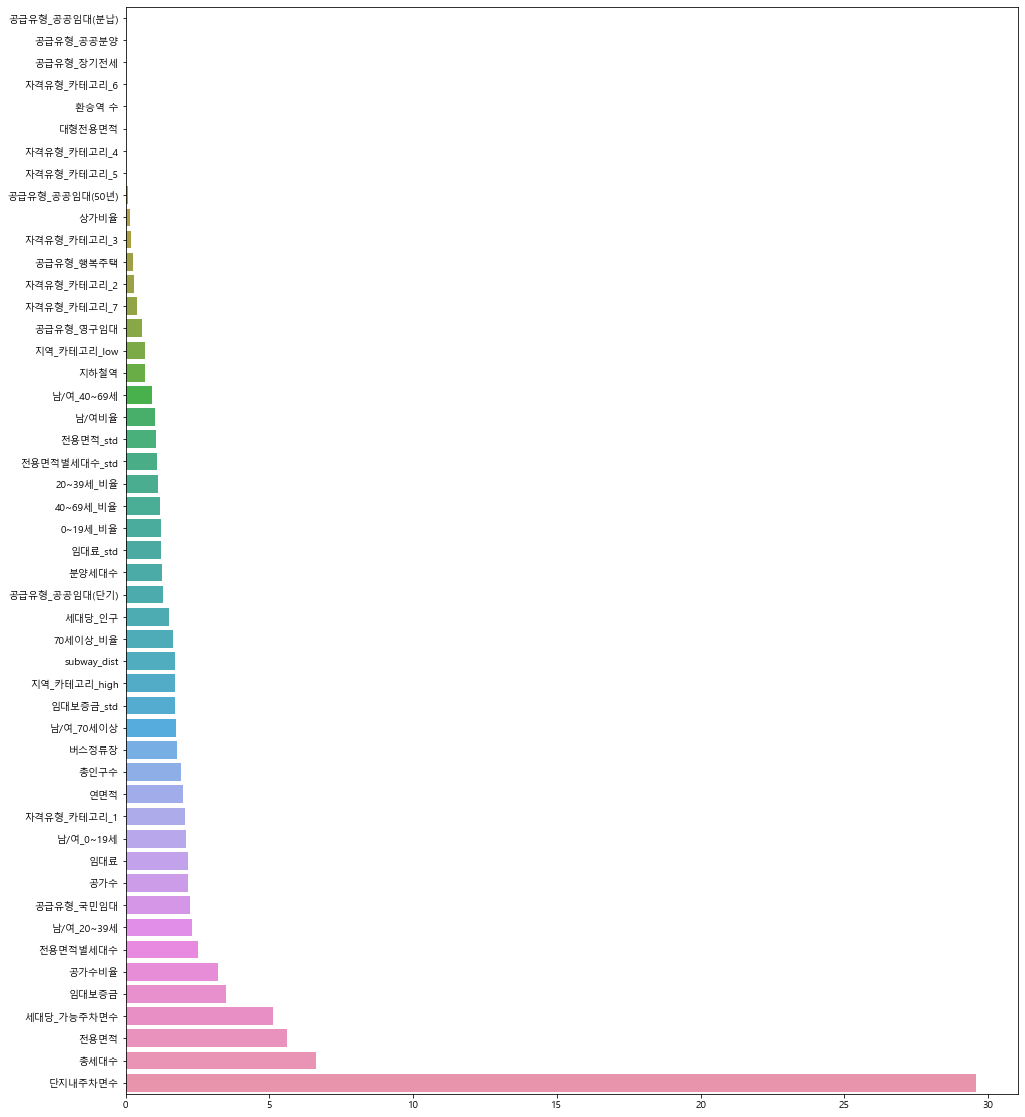

In [610]:
plt.figure(figsize=(16,20))
sns.barplot(y = X_train.columns[np.argsort(model.feature_importances_)], x = list(model.feature_importances_[np.argsort(model.feature_importances_)]))
plt.show()

#### test.csv로 predict

In [611]:
tst_pred = model.predict(test_one)
tst_predict = deepcopy(tst_pred)

In [613]:
tst_predict

array([ 224.83713762,  236.40407664,  694.06923384,  291.80361052,
         63.66881934,  307.00586611,  466.03660048,  625.55446113,
        660.93318739,  455.85041859,  574.36624344,  307.90374217,
        873.2409541 ,  926.56850507,  254.98127672,  841.15033765,
        611.12647126,  876.76941035,  268.44859284,  261.29477379,
        279.18294571,  704.41726814,  340.27375769,  158.36420218,
        234.4408673 ,  435.45318827,  902.94387547,  773.83696285,
        535.86546499,  341.72004803,  578.79079097,  364.78932281,
        605.11977247,  475.0604191 ,  264.80955461,  270.14663521,
        354.60424445, 1081.93851481,  162.93194785,  353.36645892,
        623.63618868,  556.40316837,  845.97531933,  564.34972994,
        614.17927033,  342.20797633,  171.38570818,  930.01451386,
        922.56721877,  780.49574238,  917.09895921,  992.2861983 ,
       1366.92586847,  288.53071382,  704.9571457 ,  239.7657776 ,
        294.269109  ,  420.46105622,  476.64837127,  960.59724

In [592]:
result = pd.concat([pd.DataFrame(test_one_num.index).reset_index(drop=True), pd.DataFrame(tst_predict)],axis=1)
result.columns = ["code","num"]
result
sample = pd.read_csv(os.path.join("../EDA/data","sample_submission.csv"))
sub = sample.merge(result, left_on = "code", right_on = "code",how = "left")
sub = sub[["code","num_y"]]
sub.columns = ["code","num"]
sub.loc[sub.num<0,"num"] = np.min(sub.loc[sub.num>=0,"num"])
sub.to_csv("sub0715.csv",index=False)

In [144]:
train = pre_train
test = pre_test
train1 = train.loc[train.지역_카테고리=="high",]
train2 = train.loc[train.지역_카테고리!="high",]
test1 = test.loc[test.지역_카테고리=="high",]
test2 = test.loc[test.지역_카테고리!="high",]

In [145]:
x_col = ['위도','경도','subway_name','도로명주소','지역','단지명','임대건물구분','공가수']
train1 = train1.drop(x_col, axis=1)
X = train1.drop('등록차량수',axis=1)
y1 = train1[['등록차량수','단지코드']].groupby('단지코드').mean()['등록차량수']
train1_one_num = pd.concat([X['단지코드'],X.drop('단지코드',axis=1).select_dtypes(include="number")],axis=1).groupby('단지코드').mean()

train1_obj = pd.concat([train1['단지코드'],pd.get_dummies(X.drop("단지코드",axis=1).select_dtypes(exclude="number"))],axis=1)
train1_one_obj = train1_obj.groupby('단지코드').sum()
train1_one = pd.concat([train1_one_num, train1_one_obj],axis=1)
del train1_one['지역_카테고리_high']

# x_col = ['위도','경도','subway_name','도로명주소','단지명','지역','임대건물구분']
# X = test1.drop(x_col, axis=1)
# test1_one_num = pd.concat([X['단지코드'],X.drop('단지코드',axis=1).select_dtypes(include="number")],axis=1).groupby('단지코드').mean()
# test1_obj = pd.concat([test1['단지코드'],pd.get_dummies(X.drop("단지코드",axis=1).select_dtypes(exclude="number"))],axis=1)
# test1_one_obj = test1_obj.groupby('단지코드').sum()
# test1_one = pd.concat([test1_one_num, test1_one_obj],axis=1).reset_index(drop=True)
# list(set(train1_one)-set(test1_one))
# test1_add = pd.DataFrame(np.zeros([test1_one.shape[0],2])
#                          ,columns=list(set(train1_one)-set(test1_one)))
# test1_one = pd.concat([test1_one,test1_add],axis=1)
# print(set(train1_one)-set(test1_one))

In [146]:
train2.loc[train2.공급유형=="영구임대", "임대료"]=train2.loc[train2.공급유형=="영구임대", "임대료"]*2
train2_a=train2[train2.임대건물구분=="아파트"]
sample = train2_a.groupby('단지코드').mean()[['전용면적별세대수','전용면적','임대료','임대보증금']].reset_index()
sample2 = train2_a.groupby('단지코드').std()[['전용면적별세대수','전용면적','임대료','임대보증금']].reset_index()
sample2.columns = ['단지코드','전용면적_std', '전용면적별세대수_std', '임대보증금_std', '임대료_std']
x_col = ['위도','경도','subway_name','도로명주소','지역','단지명','임대건물구분','공가수']
train2 = train2.drop(x_col, axis=1)
X = train2.drop('등록차량수',axis=1)
y2 = train2[['등록차량수','단지코드']].groupby('단지코드').mean()['등록차량수']
train2_one_num = pd.concat([X['단지코드'],X.drop('단지코드',axis=1).select_dtypes(include="number")],axis=1).groupby('단지코드').mean().reset_index(drop=False)
print(train2_one_num.columns)
train2_one_num = pd.concat([train2_one_num.drop(['전용면적별세대수','전용면적','임대료','임대보증금'],axis=1),sample],axis=1)
train2_one_num = pd.concat([train2_one_num.drop(['전용면적_std', '전용면적별세대수_std', '임대보증금_std', '임대료_std'],axis=1),sample2],axis=1)
print(train2_one_num.columns)
print(train2_one_num.shape)
train2_obj = pd.concat([train2['단지코드'],pd.get_dummies(X.drop("단지코드",axis=1).select_dtypes(exclude="number"))],axis=1)
train2_one_obj = train2_obj.groupby('단지코드').sum().reset_index(drop=False)
print(train2_one_obj.shape)
train2_one = pd.concat([train2_one_num, train2_one_obj],axis=1)
del train2_one['지역_카테고리_low']
del train2_one['단지코드']
print(train2_one.shape)
# x_col = ['위도','경도','subway_name','도로명주소','단지명','지역','임대건물구분']
# X = test2.drop(x_col, axis=1)
# test2_one_num = pd.concat([X['단지코드'],X.drop('단지코드',axis=1).select_dtypes(include="number")],axis=1).groupby('단지코드').mean()
# test2_obj = pd.concat([test2['단지코드'],pd.get_dummies(X.drop("단지코드",axis=1).select_dtypes(exclude="number"))],axis=1)
# test2_one_obj = test2_obj.groupby('단지코드').sum()
# test2_one = pd.concat([test2_one_num, test2_one_obj],axis=1).reset_index(drop=True)
# test2_add = pd.DataFrame(np.zeros([test2_one.shape[0],2]),columns=list(set(train1_one)-set(test2_one)))
# test2_one = pd.concat([test2_one,test2_add],axis=1)
# print(set(train1_one)-set(test2_one))

Index(['단지코드', '총세대수', '전용면적', '전용면적별세대수', '임대보증금', '임대료', '지하철역', '버스정류장',
       '단지내주차면수', '연면적', 'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율',
       '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율',
       '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '분양세대수', '세대당_가능주차면수',
       '공가수비율', '대형전용면적', '전용면적_std', '전용면적별세대수_std', '임대보증금_std', '임대료_std'],
      dtype='object')
Index(['단지코드', '총세대수', '지하철역', '버스정류장', '단지내주차면수', '연면적', 'subway_dist',
       '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세',
       '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율',
       '70세이상_비율', '상가비율', '분양세대수', '세대당_가능주차면수', '공가수비율', '대형전용면적', '단지코드',
       '전용면적별세대수', '전용면적', '임대료', '임대보증금', '단지코드', '전용면적_std', '전용면적별세대수_std',
       '임대보증금_std', '임대료_std'],
      dtype='object')
(205, 34)
(205, 16)
(205, 45)


In [ ]:
def to_one(data, target, drop, option):
    x_col = drop
    data = data.drop(x_col, axis=1)
    if option==True:
        y = data[[target,'단지코드']].groupby('단지코드').mean()[target]
    else:
        target = []
        y = None
    X = data.drop(target,axis=1).set_index('단지코드')
    data_one_num = X.select_dtypes(include="number").groupby('단지코드').mean()
    data_one_obj = pd.get_dummies(X.select_dtypes(exclude="number")).groupby('단지코드').sum()
    data_one = data_one_num.join(data_one_obj, how="inner")
    return data_one, y

In [67]:
X_train, X_test, y_train, y_test = train_test_split(train1_one, y1, test_size=0.3, random_state=2021,shuffle=True)

In [68]:
model = CatBoostRegressor(
#     cat_features = obj_col,
#     n_estimators = 1000,
    loss_function = 'MAE')

In [69]:
model.fit(X_train, y_train,verbose=500)
tst_pred = model.predict(X_test)
mean_absolute_error(y_test,tst_pred)

0:	learn: 298.0824649	total: 5.79ms	remaining: 5.79s
500:	learn: 18.4982732	total: 2.35s	remaining: 2.34s
999:	learn: 7.8611639	total: 4.66s	remaining: 0us


97.01633287455985

In [73]:
X_train2.shape, X_test2.shape

((143, 45), (62, 45))

In [123]:
train2_one.shape, y2.shape

((205, 53), (205,))

In [147]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(train2_one, y2, test_size=0.3, random_state=2021,shuffle=True)

In [148]:
model2 = CatBoostRegressor(
#     cat_features = obj_col,
#     n_estimators = 1000,
    loss_function = 'MAE')

In [149]:
model2.fit(X_train2, y_train2,verbose=500)
tst_pred = model2.predict(X_test2)
mean_absolute_error(y_test2,tst_pred)

0:	learn: 272.7686005	total: 7.95ms	remaining: 7.95s
500:	learn: 14.5441485	total: 2.71s	remaining: 2.7s
999:	learn: 3.2469500	total: 5.38s	remaining: 0us


139.63640324127925

In [37]:
model2.fit(X_train2, y_train2,verbose=500)
tst_pred = model2.predict(X_test2)
mean_absolute_error(y_test2,tst_pred)

0:	learn: 272.3970620	total: 7.56ms	remaining: 7.55s
500:	learn: 12.9637926	total: 2.24s	remaining: 2.23s
999:	learn: 4.1081434	total: 4.63s	remaining: 0us


142.55701646826228

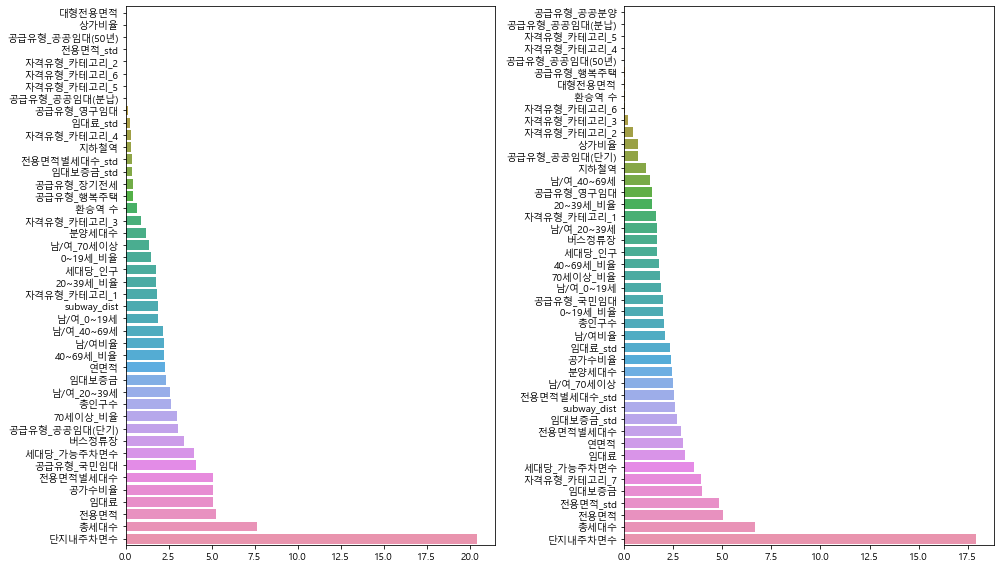

In [150]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=2)
sns.barplot(y = X_train.columns[np.argsort(model.feature_importances_)], 
            x = list(model.feature_importances_[np.argsort(model.feature_importances_)]),ax=ax[0])
sns.barplot(y = X_train2.columns[np.argsort(model2.feature_importances_)], 
            x = list(model2.feature_importances_[np.argsort(model2.feature_importances_)]),ax=ax[1])
plt.tight_layout()
plt.show()

In [154]:
train2_one.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,205.0000,722.0976,420.6675,40.0000,416.0000,630.0000,922.0000,"2,428.0000"
지하철역,205.0000,0.1610,0.4183,0.0000,0.0000,0.0000,0.0000,3.0000
버스정류장,205.0000,3.7024,2.8773,0.0000,2.0000,3.0000,5.0000,20.0000
단지내주차면수,205.0000,521.5463,359.0455,25.0000,246.0000,445.0000,707.0000,"1,756.0000"
연면적,205.0000,"3,234.2957","4,163.2875",5.6880,175.5000,"2,242.5000","5,374.8300","38,036.8600"
subway_dist,205.0000,0.3233,0.4521,0.0006,0.0307,0.1543,0.4483,1.8900
환승역 수,205.0000,1.0537,0.2259,1.0000,1.0000,1.0000,1.0000,2.0000
총인구수,205.0000,"28,436.6833","21,197.8490","2,002.0000","14,735.5000","22,311.0000","36,060.0000","120,892.0000"
세대당_인구,205.0000,2.2672,0.2691,1.5900,2.0800,2.2400,2.5100,2.8200
남/여비율,205.0000,0.9948,0.0617,0.8700,0.9600,0.9900,1.0200,1.4500


In [164]:
# pd.pivot_table(df, index = ['계정코드','계정과목'], values = '차변금액', aggfunc = 'sum')

In [173]:
pd.pivot_table(r_train, index="단지코드",values="자격유형",aggfunc=["nunique"]).value_counts()

(nunique, 자격유형)
1                  340
2                   61
3                   13
dtype: int64

In [176]:
pd.pivot_table(r_test, index="단지코드",values="자격유형",aggfunc=["nunique"]).value_counts()

(nunique, 자격유형)
1                  121
2                   24
3                    2
dtype: int64

In [174]:
pd.pivot_table(r_train, index="단지코드",values="공급유형",aggfunc=["nunique"]).value_counts()

(nunique, 공급유형)
1                  354
2                   53
3                    7
dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train[num_col])

X_train_tmp = scaler.transform(X_train[num_col])
X_test_tmp = scaler.transform(X_test[num_col])